In [2]:
import glob
import spacy
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn import metrics

In [35]:
#Problem 1


numdocs = 200 #nuber of documents to be processed
path = '/home/tobias/Documents/RobotJudge/cases/' #path to the case files



cases = []
years = []
ids = []


files = glob.glob(path + '*.txt')
nlp = spacy.load('en')
i = 0


for file in files:
    if i > numdocs:
        break
    try:
        with open(file) as open_file:
            cases.append(open_file.read())
            years.append(re.findall(path + '(\d+)', file)[0])
            id = re.findall(path + '(\d+)_(\S)(\S)(\S)(\S)(\S)(\S)', file)[0]
            ids.append(''.join(id[1:7]))
            i += 1
    except:
            print("Error reading File")    

            
def runSpacy(txt):
    return nlp(txt)

def getNumSents(doc):
    return len(list(doc.sents))

def getNumToks(doc):
    return len(list(doc))

        
df  = pd.DataFrame({'caseid':ids,'text':cases, 'year':years})
df['doc'] = df['text'].apply(runSpacy)

df['numSen'] = df['doc'].apply(getNumSents)
df['numTok'] = df['doc'].apply(getNumToks)
df['numChars'] = df['doc'].str.len()

plt.hist(df['numSen'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of Sentences")
plt.show()

plt.hist(df['numTok'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of Tokens")
plt.show()

plt.hist(df['numChars'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of chars")
plt.show()


Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File
Error reading File


KeyboardInterrupt: 

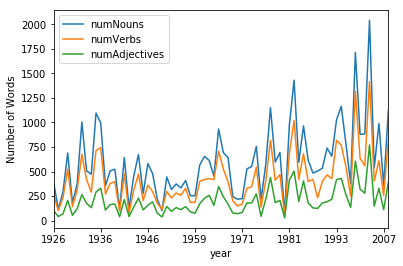

In [18]:
#Problem 2

def getNumNouns(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'NOUN':
            count += 1
    return count

def getNumVerbs(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'VERB':
            count += 1
    return count

def getNumAds(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'ADJ':
            count += 1
    return count

df['numNouns'] = df['doc'].apply(getNumNouns)
df['numVerbs'] = df['doc'].apply(getNumVerbs)
df['numAdjectives'] = df['doc'].apply(getNumAds)

ax = df.groupby('year')['numNouns'].mean().plot()
ax = df.groupby('year')['numVerbs'].mean().plot()
ax = df.groupby('year')['numAdjectives'].mean().plot()
ax.set_ylabel("Number of Words")
plt.legend()
plt.show()




In [28]:
#Problem 3
def normalize(doc): #code snippet from Solutions_01
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower() # all lower case
        nopunc = lower.translate(translator) # remove punctuation
        words = nopunc.split() # split into tokens
        no_numbers = [w if not w.isdigit() else '#' for w in words] # normalize numbers
        stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
        tokens += stemmed # add to list of tokens for this document
        #Do not remove names because some laws are named after people or places
        #Do not remove stopwords because they can be important in legal documents and I got much better results with stopwords
    return tokens


df['cleanToken'] = df['doc'].apply(normalize)

def findTriGrams(doc):
    trigram = []
    for i in range(0, len(doc) - 2):
        if doc[i+2].pos_ == 'NOUN': # and str(doc[i]) != '#' and str(doc[i+1]) != '#' and str(doc[i+2]) != '#':
            trigram.append(str(doc[i]) + " " + str(doc[i+1]) + " " + str(doc[i+2]))
                        
    return trigram
        
def makeDoc(tokens):
    return nlp(' '.join(tokens))

    
df['cleanTokenDoc'] = df['cleanToken'].apply(makeDoc)
df['trigrams'] = df['cleanTokenDoc'].apply(findTriGrams)
df['trigrams'][0][:5]


['the sole question',
 'in this case',
 'an agenc shop',
 'agenc shop arrang',
 'arrang is law']

In [29]:
#Problem 4
termFrequencies = Counter()

for trigram in df['trigrams']:
    termFrequencies.update(trigram)

x = statistics.stdev(termFrequencies.values())



trigramsList = set(x[0] for x in termFrequencies.most_common()[:1000])

freqs = []
for tris in df['trigrams']:
    count = Counter(tris)
    for key in count:
        count[key] /= x
    freqs.append({key: count[key] for key in count if key in trigramsList})

    
features = pd.DataFrame(freqs)
features['caseid'] = df['caseid']

featuresSparse = features.to_sparse()

featuresSparse.head()

,# # #,# # 6th,# # 8th,# # 9th,# # alr,# # cert,# # certiorari,# # cir,# # f2d,# # l,...,with the state,with the union,with this opinion,within # day,within the jurisdict,within the mean,within the scope,work of art,writ of habea,caseid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.25326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X21KR0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12663,NaN,...,NaN,NaN,NaN,NaN,NaN,0.379891,NaN,NaN,NaN,X2NJD6
2,0.126630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.126630,NaN,NaN,NaN,X40B69
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12663,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X9VH38
4,1.139672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XABN4A


In [30]:
#Problem 5

dfRev = pd.read_csv('/home/tobias/Documents/RobotJudge/case_reversed.csv')


join = features.merge(dfRev, on='caseid')

join.dropna(subset=['case_reversed'])

join.fillna(0, inplace=True)

logReg= LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(join.drop(columns=['case_reversed','caseid']), join['case_reversed'], test_size=0.25)

logReg.fit(X_train, y_train)
pred = logReg.predict(X_test)



print('Accuracy: ' + str(logReg.score(X_test, y_test)))
print('F1: '+ str(f1_score(y_test, pred)))

Accuracy: 0.6530612244897959
F1: 0.7213114754098361


/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy: 0.6530612244897959
F1: 0.7213114754098361


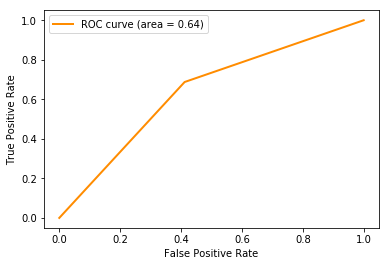

In [31]:
#Problem 6
params = {'C':[.001,.01,.1,1,10,11]}

grid = GridSearchCV(logReg,params,n_jobs=-1)
grid.fit(X_train[:100], y_train[:100])

print(grid.best_estimator_)

logReg = grid.best_estimator_
logReg.fit(X_train, y_train)
pred = logReg.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=2)
print('Accuracy: ' + str(logReg.score(X_test, y_test)))
print('F1: '+ str(f1_score(y_test, pred)))


n_classes = len(y_train)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test, pred)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
        
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

In [32]:
#Problem 7

sentences = []

for doc in df['doc']:
    for sent in doc.sents:
        sentences.append(sent)
        
sents = pd.DataFrame({'sents':sentences})

analyser = SentimentIntensityAnalyzer()

def sentimentAnalyzerScores(sentence):
    score = analyser.polarity_scores(sentence)
    return list(score.values())[3]
    
def toString(sent):
    return str(sent)

sents['sentsString'] = sents['sents'].apply(toString)
sents['score'] = sents['sentsString'].apply(sentimentAnalyzerScores)
pd.set_option('display.max_colwidth', -1)

print('Lowest compund score:')
sents[['sentsString','score']].sort_values(by=['score']).head(10)


Lowest compund score:


,sentsString,score
10140,"The district court's conclusion also ignores at least three aggravating circumstances present during the Sheppard murder that were not present during the Padgett murder: (1) the Sheppard murder was the third murder that day, while the Padgett murder was the first, (2) Parker cut Sheppard's throat to make sure the job was done, and (3) he murdered her to prevent her from identifying him as the murderer of Padgett.\n",-0.9902
3809,Fretwell argued that his counsel was ineffective because counsel failed to object to the aggravating circumstances jury instructions; because counsel failed to prepare and present evidence at the suppression hearing on Fretwell's confession; because counsel argued for an erroneously-worded jury instruction on the lesser included offense of first degree murder; and because counsel failed to investigate or prepare for the sentencing phase.\n,-0.9747
26240,"Its presence has been referred to, but the disaster or tragedy has been some additional horrible element, some terrible threat to safety that can flow from the presence of drugs--some shooting, some explosion, some crash of train, truck, or aircraft, or some breach of top secret national security.\n",-0.9744
16342,"Congress first included continuing criminal enterprise in the Drug Control Act, not as an independent crime, but as a sentencing alternative, the purpose being to severely punish those criminals who made a substantial living by violating the drug laws.\n",-0.9737
3541,"To decide whether the government has violated Ursery's constitutional right this court must make three key determinations: (1) whether the civil forfeiture in the instant case constitutes "" punishment "" for double jeopardy purposes; (2) whether the civil forfeiture and criminal conviction are punishment for the same offense; and (3) whether the civil forfeiture and criminal prosecution are separate proceedings .\n",-0.9723
16256,"The defendant argues that the crime of conspiracy charged in the first indictment was a lesser included offense of the crime of engaging in a continuing criminal enterprise, and that as such the offenses are considered the same under the double jeopardy clause.\n",-0.9698
21470,"Appellants make no claim of actual prejudice accruing from this deprivation; they argue that they do not have to make such a showing and rely on the authority of United States v. Venuto , 182 F.2d 519 (3rd Cir. 1950), which provides: The United States Court of Appeals for the Second Circuit has more recently faced an identical fact situation, however, and it has required the defendant to make some showing of prejudice before the error of the trial court in forbidding lawyer/client consultation for some limited period rises to the status of reversible error.\n",-0.9668
10030,"The jury rejected this version of the facts and on March 9, 1983, found Parker guilty of first degree murder for the deaths of Padgett and Sheppard and third degree murder for the death of Dalton.\n",-0.9657
2301,"The words 'in contemplation of death' mean that the thought of death is the impelling cause of the transfer, and while the belief in the imminence of death may afford convincing evidence, the statute is not to be limited, and its purpose thwarted, by a rule of construction which in place of contemplation of death makes the final criterion to be an apprehension that death is 'near at hand.'\n",-0.9654
3618,"The government argues that the civil forfeiture and criminal conviction here do not constitute punishment for the same offense because the criminal prosecution requires proof that a person , the defendant, committed the crime, while the forfeiture requires proof that the property subject to forfeiture has been involved in the commission of a criminal violation.\n",-0.9637


In [33]:
print('Highest compund score:')
sents[['sentsString','score']].sort_values(by=['score']).tail(10)

Highest compund score:


,sentsString,score
24097,"Turning to the evidence of original cost, the Commission found that the properties were all of comparatively recent acquisition or construction; that the accounting records had been sufficiently adequate and well maintained to permit a ready determination of all costs involved; that the major portion of all cost of Canadian and Colorado had been incurred since the adoption by such companies of an accounting system based on the Code of Accounts of the Public Service Commission of Pennsylvania; that the basic facts were clear and essentially undisputed; that they represented the best and only reliable evidence respecting property values; and that, in accordance with section 6 of the act, supra, and under the record in the proceeding, no necessity existed to consider other factors than original cost.\n",0.9694
11579,"That appellee has built and installed his patented game at various places in this country and at one place in England; that he has granted numerous patent licenses thereon; that the patent has been held valid and infringed as to all its claims in the case of Gibbs v. T. Z. R. Amusement Corporation , supra , and has been held valid and infringed, upon stipulation of the parties, by consent judgments in six cases in United States District Courts in the States of California, Connecticut and New York; that appellant is the only one refusing to recognize the validity of appellee's patent; that the Gibbs patent is neither ambiguous nor indefinite in either its specifications and claims, but is fully understandable by any one skilled in the art and complies with Revised Statutes Section 4888, 35 U.S.C.A. 33; that appellee is the sole inventor; that 14 Letters Patent covering other game devices offered in evidence together with a certain catalog dated 1929, do not disclose, or anticipate, or suggest either singly or collectively, the subject matter of the Gibbs patent, nor do these documents furnish any basis for any finding or conclusion that the Gibbs patent lacks invention; that appellee has complied with the provisions of 35 U.S.C.A. 49; that appellant's Fawn game is in two forms, one being the original, which was modified after the commencement of this litigation, but the modified Fawn game embodies the same physical structure, function and appearance as the original Fawn game with certain changes, which are of such a character that it would require only a few minutes work to restore it to its exact original form; that the electrical wiring for the original circuits remains intact in the altered game with only a difference in the terminal connection of one wire.\n",0.9696
27137,"A virtually unbroken line of cases supports the Tax Court in holding that if the grant of a stock option by a corporation to its employee is intended as additional compensation to him the excess of the fair market value over the option price is income taxable to him when the option is exercised, but on the other hand if the grant of the option is intended to provide him with a proprietary interest in the business no taxable gain is recognized when the option is exercised, whether the grant of the option is the one or the other being in every case a question of fact.\n",0.9700
15384,"As realists we know that those who seek reelection to judicial office hope that their conduct will find public approval, but we do not think that judicial misconduct would be more attractive to the electorate than conduct marked by the integrity which we as judges like to believe is possessed by elected judges as well as those who have the security of tenure during ""good behavior.""\n",0.9737
21482,"'Gross Income' includes gains, profits, and income derived from salaries, wages, or compensation for personal service (including personal service as an officer or employee of a State, or any political subdivision thereof, or any agency or instrumentality of any one or more of the foregoing), of whatever kind and in whatever form paid, or from pr

In [34]:
#Problem 8

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sents['sentsString'])

sentsCount = 2000 #Calculating cosine similarity of more sentences takes a lot of time and there are already interesting results with 2000 sentences 

sim = cosine_similarity(X[:sentsCount])

maxv = 0.0
minv = 1.0
maxi = [0, 0, 0, 0, 0]
maxj = [0, 0, 0, 0, 0]
mini = [0, 0, 0, 0, 0]
minj = [0, 0, 0, 0, 0]


for k in range(5):
    for i in range(sentsCount):
        for j in range(sentsCount):
            if sim[i][j] > maxv and i != j and sim[i][j] < 1: #Equal sentences are boring
                maxv = sim[i][j]
                sim[i][j] = 0.5
                sim[j][i] = 0.5
                maxi[k] = i
                maxj[k] = j
                
            if sim[i][j] < minv and sim[i][j] > 0: #Sentences with similarity 0 are boring
                minv = sim[i][j]
                sim[i][j] = 0.5
                sim[j][i] = 0.5
                mini[k] = i
                minj[k] = j
    maxv = 0
    minv = 1.0
    
print('Very similar sentences: ')
for i in range(5):
    print("Sentences ",maxi[i], " and ", maxj[i], ":")
    print(sents['sentsString'][maxi[i]]) 
    print('')
    print(sents['sentsString'][maxj[i]])
    print('')
    
print('Very unsimilar sentences: ')
print('')
for i in range(5):
    print("Sentences ",mini[i], " and ", minj[i], ":")
    print(sents['sentsString'][mini[i]]) 
    print('')
    print(sents['sentsString'][minj[i]])
    print('')

Very similar sentences: 
Sentences  1481  and  1690 :
United States v. Playboy Entertainment Group, Inc. , 529 U.S. 803 , 120 S.Ct.

See United States v. Playboy Entertainment Group, Inc. , 529 U.S. 803 , 120 S.Ct.

Sentences  1760  and  1767 :
See ABA Model Code of Jud.


ABA Model Code of Jud.


Sentences  1536  and  1873 :
See Shrink Mo. , 120 S.Ct.

Shrink Mo. , 120 S.Ct.

Sentences  1777  and  1873 :
See Shrink Mo. , 120 S.Ct.

Shrink Mo. , 120 S.Ct.

Sentences  1777  and  1881 :
See Shrink Mo. , 120 S.Ct.

See also Shrink Mo. , 120 S.Ct.

Very unsimilar sentences: 

Sentences  961  and  1209 :
See, e.g. , Affiliated Ute Citizens , supra (employees of a bank acting as stock transfer agent who "facilitated" sales of shares); Capital Gains Research Bureau , supra (financial adviser, under the Investment Advisers Act of 1940); Zweig v. Hearst Corp. , 594 F.2d 1261

Canon 5 restricts candidates for judicial office from attending and speaking at partisan political gatherings; identifyi

In [11]:
#Problem 9

numClusters = 20
km = KMeans(n_clusters=numClusters,n_jobs=-1)
km.fit(X[:1000])

docClusters = km.labels_.tolist()
dfs = sents[:1000]


dfs['cluster'] = docClusters
dfs[dfs['cluster']==1]['sentsString']
dfs[dfs['cluster']==2]['sentsString']

for i in range(20):
    print('CLUSTER: ', i)
    print(dfs[dfs['cluster']==i]['sentsString'].head(5))

CLUSTER:  0
0      PER CURIAM.\n                        
2     29 U.S.C.A. 151-166 , as amended.\n   
7     "\n                                   
9     Burns' Indiana Statutes Ann.\n        
23    We believe it is entirely different.\n
Name: sentsString, dtype: object
CLUSTER:  1
739    But whether rights of action for injunction and restitution were kept alive requires consideration of the function of an injunction suit and the relation of restitution to such injunction suit.\n                     
741    It follows, therefore, that the plaintiff, at the time of the filing of this suit, had no valid, surviving cause of action in equity for injunction after the termination of rent control.\n                            
742    Consequently the Court below should have dismissed so much of the plaintiff's suit as sought injunction, as well as its prayer for restitution if restitution is merely an incident to the equity suit for injunction.\n
746    1332 , a notion that restitution is in 

/home/tobias/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
